In [61]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['font.size'] = 10

# Modeling and Forecasting
# ==============================================================================
import sklearn
from sklearn.linear_model import Ridge

from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.linear_model import BayesianRidge
from skforecast.recursive import ForecasterSarimax

from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import skforecast
from skforecast.recursive import ForecasterRecursive
from skforecast.direct import ForecasterDirect
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import grid_search_forecaster

import shap

import warnings

In [62]:
# Data load
# ==============================================================================
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

In [63]:
train.head(10)

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0
5,5,2010-01-01,Canada,Stickers for Less,Holographic Goose,300.0
6,6,2010-01-01,Canada,Stickers for Less,Kaggle,1837.0
7,7,2010-01-01,Canada,Stickers for Less,Kaggle Tiers,1659.0
8,8,2010-01-01,Canada,Stickers for Less,Kerneler,807.0
9,9,2010-01-01,Canada,Stickers for Less,Kerneler Dark Mode,940.0


In [64]:
train.tail()

,id,date,country,store,product,num_sold
230125,230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0
230126,230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0
230127,230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0
230128,230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.0
230129,230129,2016-12-31,Singapore,Premium Sticker Mart,Kerneler Dark Mode,1622.0


There are several repeated dates, I am going to analize how many distinct entries there are for each unique date. With this purpose, I am going to group by date, which will return the different combinations in each date.

In [65]:
groups_by_date = train.groupby(['date']).size()
groups_by_date.info()

<class 'pandas.core.series.Series'>
Index: 2557 entries, 2010-01-01 to 2016-12-31
Series name: None
Non-Null Count  Dtype
--------------  -----
2557 non-null   int64
dtypes: int64(1)
memory usage: 40.0+ KB


In [67]:
n_groups_by_date = groups_by_date.value_counts()
n_groups_by_date

90    2557
Name: count, dtype: int64

In [68]:
n_dates= list(n_groups_by_date)[0]

In [69]:
n_groups=list(n_groups_by_date.index)[0]

In [70]:
print(f"There are {n_groups} different combinations of 'country', 'store' and 'product' for each individual date, of which there are {n_dates}.")

There are 90 different combinations of 'country', 'store' and 'product' for each individual date, of which there are 2557.


I need to predict each combination individually. To facilitate the automatization of the predictions, I will store all the different dataframes each containing a different product, store and country in a dictionary.  

In [71]:
# Data preparation
# ==============================================================================
train['date'] = pd.to_datetime(train['date'], format='%Y-%m-%d')
print(train['date'].dtypes)
train = train.set_index('date')
train = train.sort_index()

datetime64[ns]


In [72]:
grouped = train.groupby(['country','store','product'])

In [73]:
grouped_dataframes = {key: group for key, group in grouped}

In [74]:
# Data preparation
# ==============================================================================
for key in grouped_dataframes.keys():
    grouped_dataframes[key] = grouped_dataframes[key].asfreq('D')
    grouped_dataframes[key] = grouped_dataframes[key].sort_index()

In [83]:
rebuild_df = pd.concat(grouped_dataframes.values()) 


In [84]:
rebuild_df.sort_values('id')

,id,country,store,product,num_sold,preds
date,,,,,,
2010-01-01,0,Canada,Discount Stickers,Holographic Goose,NaN,1
2010-01-01,1,Canada,Discount Stickers,Kaggle,973.0,1
2010-01-01,2,Canada,Discount Stickers,Kaggle Tiers,906.0,1
2010-01-01,3,Canada,Discount Stickers,Kerneler,423.0,1
2010-01-01,4,Canada,Discount Stickers,Kerneler Dark Mode,491.0,1
...,...,...,...,...,...,...
2016-12-31,230125,Singapore,Premium Sticker Mart,Holographic Goose,466.0,1
2016-12-31,230126,Singapore,Premium Sticker Mart,Kaggle,2907.0,1
2016-12-31,230127,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0,1


usamos este loop para, si en todo NaNs, cambiarlo todo por zeroes
si hay algunos NaNs, cambiarlo por la media de los puntos anterior y posterior

In [14]:
example_df= grouped_dataframes[('Finland', 'Discount Stickers', 'Kaggle Tiers')]

In [15]:
example_df

,id,country,store,product,num_sold
date,,,,,
2010-01-01,17,Finland,Discount Stickers,Kaggle Tiers,774.0
2010-01-02,107,Finland,Discount Stickers,Kaggle Tiers,764.0
2010-01-03,197,Finland,Discount Stickers,Kaggle Tiers,815.0
2010-01-04,287,Finland,Discount Stickers,Kaggle Tiers,664.0
2010-01-05,377,Finland,Discount Stickers,Kaggle Tiers,608.0
...,...,...,...,...,...
2016-12-27,229697,Finland,Discount Stickers,Kaggle Tiers,585.0
2016-12-28,229787,Finland,Discount Stickers,Kaggle Tiers,657.0
2016-12-29,229877,Finland,Discount Stickers,Kaggle Tiers,722.0


In [16]:
example_df['num_sold'].isna().sum()

0

In [17]:
def fill_with_mean_neighbor(series):
    for i in range(len(series)):
        if pd.isna(series.iloc[i]):  # Verificar si es NaN
            # Obtener el valor anterior y posterior
            prev_val = series.iloc[i - 1] if i > 0 else np.nan
            next_val = series.iloc[i + 1] if i < len(series) - 1 else np.nan
            
            # Calcular la media de los valores no nulos
            neighbors = [val for val in [prev_val, next_val] if not pd.isna(val)]
            series.iloc[i] = np.mean(neighbors) if neighbors else np.nan
    return series

In [18]:
example_df.index

DatetimeIndex(['2010-01-01', '2010-01-02', '2010-01-03', '2010-01-04',
               '2010-01-05', '2010-01-06', '2010-01-07', '2010-01-08',
               '2010-01-09', '2010-01-10',
               ...
               '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25',
               '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2016-12-31'],
              dtype='datetime64[ns]', name='date', length=2557, freq='D')

In [19]:
# Missing values
# ==============================================================================
print(f'Number of rows with missing values: {example_df.isnull().any(axis=1).sum()}')

Number of rows with missing values: 0


There are many missing values, all in the 'num_sold' column, but no 0 values. I think it is safe to assume that missing values mean 'no sales', so I will transform them into '0'

Apparently, the nan values come from non-existent combinations. Those must be stores that don't exist or have not report their sales. I'm going to develop a method to check wheter this is true. This way, I can remove the nan values from the main dataframe 'train' being sure that no date points are deleted, thus creating gaps.

Try a for loop doing two list, one adding up a total value of 0 nulls, other adding up 2557, and other adding up something in the middle, that would need to be processed.

In [20]:
all_nans_list = []
no_nans_list = []
some_nans_list = []

for key, group in grouped_dataframes.items():
    if group.isnull().any(axis=1).sum() == 0:
        no_nans_list.append(key)
    elif group.isnull().any(axis=1).sum() == len(group):
        group.fillna(0, inplace=True)
        all_nans_list.append(key)
    else:
        group.apply(fill_with_mean_neighbor)
        some_nans_list.append(key)

In [21]:
some_nans_list[1]

('Canada', 'Premium Sticker Mart', 'Holographic Goose')

In [22]:
grouped_dataframes[some_nans_list[1]]['num_sold'].isna().sum()

0

In [57]:
list(grouped_dataframes.values())

[                id country              store            product  num_sold
 date                                                                      
 2010-01-01       0  Canada  Discount Stickers  Holographic Goose       0.0
 2010-01-02      90  Canada  Discount Stickers  Holographic Goose       0.0
 2010-01-03     180  Canada  Discount Stickers  Holographic Goose       0.0
 2010-01-04     270  Canada  Discount Stickers  Holographic Goose       0.0
 2010-01-05     360  Canada  Discount Stickers  Holographic Goose       0.0
 ...            ...     ...                ...                ...       ...
 2016-12-27  229680  Canada  Discount Stickers  Holographic Goose       0.0
 2016-12-28  229770  Canada  Discount Stickers  Holographic Goose       0.0
 2016-12-29  229860  Canada  Discount Stickers  Holographic Goose       0.0
 2016-12-30  229950  Canada  Discount Stickers  Holographic Goose       0.0
 2016-12-31  230040  Canada  Discount Stickers  Holographic Goose       0.0
 
 [2557 row

In [23]:
example_some_nan_df = grouped_dataframes[some_nans_list[1]]

In [24]:
example_some_nan_df.iloc[0]

id                            10
country                   Canada
store       Premium Sticker Mart
product        Holographic Goose
num_sold                   375.0
Name: 2010-01-01 00:00:00, dtype: object

In [25]:
nan_clean = example_some_nan_df.apply(fill_with_mean_neighbor)

In [26]:
nan_clean.isna().sum()

id          0
country     0
store       0
product     0
num_sold    0
dtype: int64

In [27]:
print(f'Number of dataframes without values: {len(all_nans_list)}')
print(f'Number of dataframes without NaNs: {len(no_nans_list)}')
print(f'Number of dataframes with some NaNs: {len(some_nans_list)}')

Number of dataframes without values: 2
Number of dataframes without NaNs: 81
Number of dataframes with some NaNs: 7


In [28]:
train.head(50)

,id,country,store,product,num_sold
date,,,,,
2010-01-01,0,Canada,Discount Stickers,Holographic Goose,NaN
2010-01-01,1,Canada,Discount Stickers,Kaggle,973.0
2010-01-01,2,Canada,Discount Stickers,Kaggle Tiers,906.0
2010-01-01,3,Canada,Discount Stickers,Kerneler,423.0
2010-01-01,4,Canada,Discount Stickers,Kerneler Dark Mode,491.0
2010-01-01,5,Canada,Stickers for Less,Holographic Goose,300.0
2010-01-01,6,Canada,Stickers for Less,Kaggle,1837.0
2010-01-01,7,Canada,Stickers for Less,Kaggle Tiers,1659.0
2010-01-01,8,Canada,Stickers for Less,Kerneler,807.0


In [29]:
no_nans_list

[('Canada', 'Discount Stickers', 'Kaggle'),
 ('Canada', 'Discount Stickers', 'Kaggle Tiers'),
 ('Canada', 'Discount Stickers', 'Kerneler Dark Mode'),
 ('Canada', 'Premium Sticker Mart', 'Kaggle'),
 ('Canada', 'Premium Sticker Mart', 'Kaggle Tiers'),
 ('Canada', 'Premium Sticker Mart', 'Kerneler'),
 ('Canada', 'Premium Sticker Mart', 'Kerneler Dark Mode'),
 ('Canada', 'Stickers for Less', 'Kaggle'),
 ('Canada', 'Stickers for Less', 'Kaggle Tiers'),
 ('Canada', 'Stickers for Less', 'Kerneler'),
 ('Canada', 'Stickers for Less', 'Kerneler Dark Mode'),
 ('Finland', 'Discount Stickers', 'Holographic Goose'),
 ('Finland', 'Discount Stickers', 'Kaggle'),
 ('Finland', 'Discount Stickers', 'Kaggle Tiers'),
 ('Finland', 'Discount Stickers', 'Kerneler'),
 ('Finland', 'Discount Stickers', 'Kerneler Dark Mode'),
 ('Finland', 'Premium Sticker Mart', 'Holographic Goose'),
 ('Finland', 'Premium Sticker Mart', 'Kaggle'),
 ('Finland', 'Premium Sticker Mart', 'Kaggle Tiers'),
 ('Finland', 'Premium Sticker

In [30]:
for df in some_nans_list:
    print(df, 'Number of NaNs: ', grouped_dataframes[df].isnull().any(axis=1).sum(), 'out of ', len(grouped_dataframes[df]))

('Canada', 'Discount Stickers', 'Kerneler') Number of NaNs:  0 out of  2557
('Canada', 'Premium Sticker Mart', 'Holographic Goose') Number of NaNs:  0 out of  2557
('Canada', 'Stickers for Less', 'Holographic Goose') Number of NaNs:  0 out of  2557
('Kenya', 'Discount Stickers', 'Kerneler') Number of NaNs:  0 out of  2557
('Kenya', 'Discount Stickers', 'Kerneler Dark Mode') Number of NaNs:  0 out of  2557
('Kenya', 'Premium Sticker Mart', 'Holographic Goose') Number of NaNs:  0 out of  2557
('Kenya', 'Stickers for Less', 'Holographic Goose') Number of NaNs:  0 out of  2557


In [31]:
# Verify that a temporary index is complete
# ==============================================================================
faulty_df = []
for key, group in grouped_dataframes.items():
    group = example_df
    start_date = group.index.min()
    end_date = group.index.max()
    complete_date_range = pd.date_range(start=start_date, end=end_date, freq=group.index.freq)
    is_index_complete = (group.index == complete_date_range).all()
    if not is_index_complete:
        faulty_df.append(group)
print(f'Number of dataframes with uncomplete index: ', len(faulty_df))

Number of dataframes with uncomplete index:  0


Train dates : 2010-01-01 00:00:00 --- 2016-12-31 00:00:00  (n=2557)
Test dates  : 0 --- 98549  (n=98550)


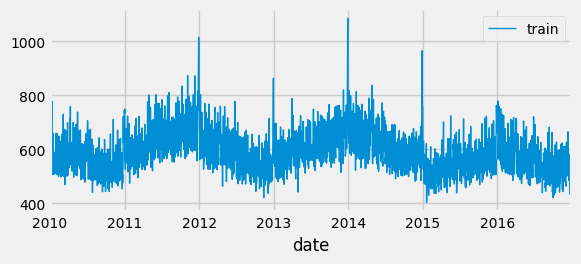

In [32]:
# Graphic representation of train-test
# ==============================================================================
train_plot = example_df
print(
    f"Train dates : {train_plot.index.min()} --- "
    f"{train_plot.index.max()}  (n={len(train_plot)})"
)
print(
    f"Test dates  : {test.index.min()} --- "
    f"{test.index.max()}  (n={len(test)})"
)

fig, ax = plt.subplots(figsize=(6, 2.5))
train_plot['num_sold'].plot(ax=ax, kind='line',label='train')

ax.legend()

In [33]:
example_df.index

DatetimeIndex(['2010-01-01', '2010-01-02', '2010-01-03', '2010-01-04',
               '2010-01-05', '2010-01-06', '2010-01-07', '2010-01-08',
               '2010-01-09', '2010-01-10',
               ...
               '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25',
               '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2016-12-31'],
              dtype='datetime64[ns]', name='date', length=2557, freq='D')

Recursive Multi-Step Forecasting

Train dates : 2010-01-01 00:00:00 --- 2015-06-18 00:00:00  (n=1995)
Test dates  : 2015-06-19 00:00:00 --- 2016-12-31 00:00:00  (n=562)


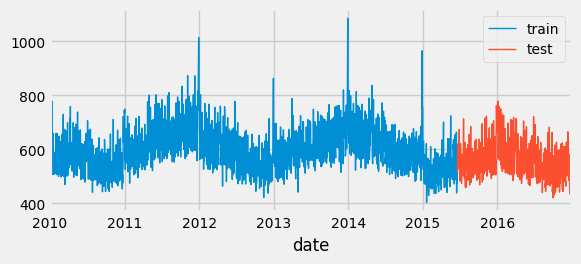

In [34]:
# Split data into train-test
# ==============================================================================
steps = 562
data_train = example_df[:-steps]
data_test  = example_df[-steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['num_sold'].plot(ax=ax, label='train')
data_test['num_sold'].plot(ax=ax, label='test')
ax.legend()

In [35]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = LGBMRegressor(random_state=123),
                 lags      = 6
             )
forecaster.fit(y=data_train['num_sold'])
forecaster

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 588.929613


=================== 
ForecasterRecursive 
=================== 
Regressor: LGBMRegressor 
Lags: [1 2 3 4 5 6] 
Window features: None 
Window size: 6 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2010-01-01 00:00:00'), Timestamp('2015-06-18 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0} 
fit_kwargs: {} 
Creation date: 2025-01-15 20:01:28 
Last fit date: 2025-01-15 20:01:28 
Skforecast version: 0.14.0 
Python version: 3.12.5 
Forecaster id: None

In [36]:
# Predictions
# ==============================================================================
steps = 562
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2015-06-19    535.733088
2015-06-20    595.209831
2015-06-21    516.397006
2015-06-22    519.608813
2015-06-23    521.649680
Freq: D, Name: pred, dtype: float64

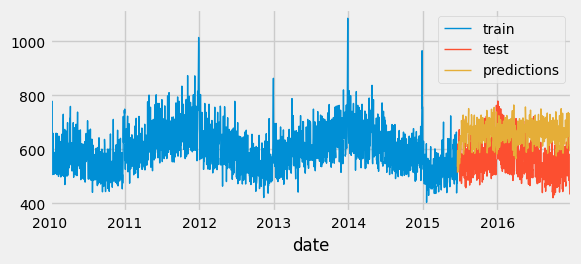

In [37]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['num_sold'].plot(ax=ax, label='train')
data_test['num_sold'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

In [38]:
# Test error
# ==============================================================================
error_rmse = root_mean_squared_error(
                y_true = data_test['num_sold'],
                y_pred = predictions
            )
error_mape = mean_absolute_percentage_error(
                y_true = data_test['num_sold'],
                y_pred = predictions
            )
print(f"Test error (RMSE): {round(error_rmse, 2)}")
print(f"Test error (MAPE): {round(error_mape*100, 2)}%")

Test error (RMSE): 127.15
Test error (MAPE): 20.95%


In [39]:
# Hyperparameter Grid search
# ==============================================================================
from skforecast.exceptions import LongTrainingWarning
warnings.simplefilter('ignore', category=LongTrainingWarning)

forecaster = ForecasterDirect(
                 regressor     = Ridge(random_state=123),
                 steps         = 562,
                 lags          = 8,  # This value will be replaced in the grid search
                 transformer_y = StandardScaler()
             )

cv = TimeSeriesFold(
         steps              = 36, 
         initial_train_size = int(len(data_train) * 0.5),
         fixed_train_size   = False,
         refit              = False,
)

param_grid = {'alpha': np.logspace(-5, 5, 10)}

lags_grid = [5, 12, 20]

results_grid = grid_search_forecaster(
                    forecaster         = forecaster,
                    y                  = data_train['num_sold'],
                    cv                 = cv,
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    metric             = 'mean_squared_error',
                    return_best        = True,
                    n_jobs             = 'auto',
                    verbose            = False
                )

lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 3425.5447977890312


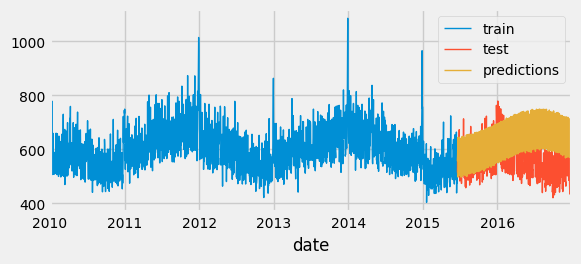

In [40]:
# Predictions
# ==============================================================================
predictions = forecaster.predict()

# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['num_sold'].plot(ax=ax, label='train')
data_test['num_sold'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

In [41]:
# Test error
# ==============================================================================
error_rmse = root_mean_squared_error(
                y_true = data_test['num_sold'],
                y_pred = predictions
            )
error_mape = mean_absolute_percentage_error(
                y_true = data_test['num_sold'],
                y_pred = predictions
            )
print(f"Test error (RMSE): {round(error_rmse, 2)}")
print(f"Test error (MAPE): {round(error_mape*100, 2)}%")

Test error (RMSE): 83.74
Test error (MAPE): 12.92%


For every dataset:

In [ ]:
steps = 562
mape_list = []
rmse_list = []
for key in list(grouped_dataframes.keys()):
    data_train = grouped_dataframes[key][:-steps]
    data_test  = grouped_dataframes[key][-steps:]
    
    forecaster = ForecasterRecursive(
                 regressor = LGBMRegressor(random_state=123),
                 lags      = 6
             )
    forecaster.fit(y=data_train['num_sold'])

    forecaster = ForecasterDirect(
                 regressor     = Ridge(random_state=123),
                 steps         = 562,
                 lags          = 8,  # This value will be replaced in the grid search
                 transformer_y = StandardScaler()
             )

    cv = TimeSeriesFold(
         steps              = 36, 
         initial_train_size = int(len(data_train) * 0.5),
         fixed_train_size   = False,
         refit              = False,
    )

    param_grid = {'alpha': np.logspace(-5, 5, 10)}

    lags_grid = [5, 12, 20]

    results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['num_sold'],
                        cv                 = cv,
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        metric             = 'mean_squared_error',
                        return_best        = True,
                        n_jobs             = 'auto',
                        verbose            = False
                    )
    
    predictions = forecaster.predict()
    # grouped_dataframes[key]['prediction'] = predictions --> this should be done with the test data

    error_rmse = root_mean_squared_error(
                y_true = data_test['num_sold'],
                y_pred = predictions
            )
    error_mape = mean_absolute_percentage_error(
                y_true = data_test['num_sold'],
                y_pred = predictions
            )
    
    print(key)
    rmse_list.append(error_rmse)
    print(f"Test error (RMSE): {round(error_rmse, 2)}")
    mape_list.append(error_mape)
    print(f"Test error (MAPE): {round(error_mape*100, 2)}%")

print('Mean RMSE: ', np.mean(rmse_list))
print('Mean MAPE: ', np.mean(mape_list))



[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 0
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped trainin

lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'alpha': 1e-05}
  Backtesting metric: 0.0
('Canada', 'Discount Stickers', 'Holographic Goose')
Test error (RMSE): 0.0
Test error (MAPE): 0.0%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 736.278532


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 3799.218803229905
('Canada', 'Discount Stickers', 'Kaggle')
Test error (RMSE): 136.25
Test error (MAPE): 19.81%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 607.013575


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 3.593813663804626}
  Backtesting metric: 3084.9871797385936
('Canada', 'Discount Stickers', 'Kaggle Tiers')
Test error (RMSE): 122.58
Test error (MAPE): 19.82%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1488
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 329.510307


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 1226.1790810947336
('Canada', 'Discount Stickers', 'Kerneler')
Test error (RMSE): 60.11
Test error (MAPE): 17.38%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1524
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 392.070890


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 1791.8159312311475
('Canada', 'Discount Stickers', 'Kerneler Dark Mode')
Test error (RMSE): 76.82
Test error (MAPE): 22.69%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 888
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 249.327300


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 581.6798706712634
('Canada', 'Premium Sticker Mart', 'Holographic Goose')
Test error (RMSE): 35.1
Test error (MAPE): 13.67%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 1762.984917


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 21191.155032438008
('Canada', 'Premium Sticker Mart', 'Kaggle')
Test error (RMSE): 352.0
Test error (MAPE): 21.37%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 1452.735546


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 16491.868363091122
('Canada', 'Premium Sticker Mart', 'Kaggle Tiers')
Test error (RMSE): 282.43
Test error (MAPE): 19.56%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 786.883358


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 6920.27910452354
('Canada', 'Premium Sticker Mart', 'Kerneler')
Test error (RMSE): 138.87
Test error (MAPE): 16.91%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 938.933132


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 9026.791703450996
('Canada', 'Premium Sticker Mart', 'Kerneler Dark Mode')
Test error (RMSE): 203.04
Test error (MAPE): 24.67%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 225.527652


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 365.59853460670746
('Canada', 'Stickers for Less', 'Holographic Goose')
Test error (RMSE): 18.99
Test error (MAPE): 7.61%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 1491.588738


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 15783.603213890854
('Canada', 'Stickers for Less', 'Kaggle')
Test error (RMSE): 285.55
Test error (MAPE): 20.23%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 1228.232780


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 3.593813663804626}
  Backtesting metric: 10682.333210804505
('Canada', 'Stickers for Less', 'Kaggle Tiers')
Test error (RMSE): 245.1
Test error (MAPE): 19.79%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 667.811966


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 4643.847101953923
('Canada', 'Stickers for Less', 'Kerneler')
Test error (RMSE): 120.92
Test error (MAPE): 17.72%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 792.028658


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 6200.1694038791775
('Canada', 'Stickers for Less', 'Kerneler Dark Mode')
Test error (RMSE): 166.04
Test error (MAPE): 24.17%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 483
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 99.614379


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 150.12893218116818
('Finland', 'Discount Stickers', 'Holographic Goose')
Test error (RMSE): 12.62
Test error (MAPE): 12.14%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 716.876823


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 4886.291489822008
('Finland', 'Discount Stickers', 'Kaggle')
Test error (RMSE): 99.07
Test error (MAPE): 13.67%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 588.929613


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 3425.5447977890312
('Finland', 'Discount Stickers', 'Kaggle Tiers')
Test error (RMSE): 83.74
Test error (MAPE): 12.92%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1432
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 319.528909


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 1446.1909437313232
('Finland', 'Discount Stickers', 'Kerneler')
Test error (RMSE): 42.16
Test error (MAPE): 11.61%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 382.330820


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 2252.0778616488324
('Finland', 'Discount Stickers', 'Kerneler Dark Mode')
Test error (RMSE): 64.41
Test error (MAPE): 18.33%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 958
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 239.100050


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 599.4842503189421}
  Backtesting metric: 928.7091022130072
('Finland', 'Premium Sticker Mart', 'Holographic Goose')
Test error (RMSE): 32.49
Test error (MAPE): 13.45%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 1714.242836


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 29871.743399218427
('Finland', 'Premium Sticker Mart', 'Kaggle')
Test error (RMSE): 238.86
Test error (MAPE): 13.5%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 1408.243338


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 18024.69770393769
('Finland', 'Premium Sticker Mart', 'Kaggle Tiers')
Test error (RMSE): 220.0
Test error (MAPE): 14.19%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 764.436400


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 599.4842503189421}
  Backtesting metric: 8974.14268079444
('Finland', 'Premium Sticker Mart', 'Kerneler')
Test error (RMSE): 109.62
Test error (MAPE): 12.66%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 915.645551


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 12739.592211060812
('Finland', 'Premium Sticker Mart', 'Kerneler Dark Mode')
Test error (RMSE): 165.84
Test error (MAPE): 19.46%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 837
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 202.085470


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 563.5613464228841
('Finland', 'Stickers for Less', 'Holographic Goose')
Test error (RMSE): 27.7
Test error (MAPE): 13.13%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 1451.672700


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 21760.855414582475
('Finland', 'Stickers for Less', 'Kaggle')
Test error (RMSE): 206.51
Test error (MAPE): 14.06%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 1190.257919


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 14238.410073537763
('Finland', 'Stickers for Less', 'Kaggle Tiers')
Test error (RMSE): 173.45
Test error (MAPE): 13.23%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 646.793866


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 5774.6267742456
('Finland', 'Stickers for Less', 'Kerneler')
Test error (RMSE): 87.98
Test error (MAPE): 12.18%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 772.582202


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 8007.403829835109
('Finland', 'Stickers for Less', 'Kerneler Dark Mode')
Test error (RMSE): 118.38
Test error (MAPE): 16.32%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 375
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 72.616390


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 61.97065272087726
('Italy', 'Discount Stickers', 'Holographic Goose')
Test error (RMSE): 10.94
Test error (MAPE): 15.55%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1512
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 523.190045


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 2121.459281483851
('Italy', 'Discount Stickers', 'Kaggle')
Test error (RMSE): 86.22
Test error (MAPE): 16.85%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 430.483660


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 1542.3115949282924
('Italy', 'Discount Stickers', 'Kaggle Tiers')
Test error (RMSE): 67.05
Test error (MAPE): 15.13%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1051
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 233.510307


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 685.9193375466272
('Italy', 'Discount Stickers', 'Kerneler')
Test error (RMSE): 35.9
Test error (MAPE): 14.25%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1245
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 278.106586


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 966.7574920239009
('Italy', 'Discount Stickers', 'Kerneler Dark Mode')
Test error (RMSE): 59.47
Test error (MAPE): 24.14%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 763
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 174.665661


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 381.54102922156943
('Italy', 'Premium Sticker Mart', 'Holographic Goose')
Test error (RMSE): 27.56
Test error (MAPE): 15.95%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 1251.325289


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 12046.611527594294
('Italy', 'Premium Sticker Mart', 'Kaggle')
Test error (RMSE): 210.54
Test error (MAPE): 17.28%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 1028.998492


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 3.593813663804626}
  Backtesting metric: 9338.733047654341
('Italy', 'Premium Sticker Mart', 'Kaggle Tiers')
Test error (RMSE): 165.35
Test error (MAPE): 15.49%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 558.840121


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 3594.0697101979003
('Italy', 'Premium Sticker Mart', 'Kerneler')
Test error (RMSE): 84.05
Test error (MAPE): 14.05%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 666.510809


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 5097.137438349971
('Italy', 'Premium Sticker Mart', 'Kerneler Dark Mode')
Test error (RMSE): 115.65
Test error (MAPE): 19.1%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 655
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 147.456008


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 235.44979920108872
('Italy', 'Stickers for Less', 'Holographic Goose')
Test error (RMSE): 21.78
Test error (MAPE): 15.09%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 1058.221719


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 8232.673893802938
('Italy', 'Stickers for Less', 'Kaggle')
Test error (RMSE): 169.95
Test error (MAPE): 16.84%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 870.520362


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 3.593813663804626}
  Backtesting metric: 6598.030493647289
('Italy', 'Stickers for Less', 'Kaggle Tiers')
Test error (RMSE): 144.69
Test error (MAPE): 16.15%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 472.983409


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 2561.9566781840713
('Italy', 'Stickers for Less', 'Kerneler')
Test error (RMSE): 77.87
Test error (MAPE): 15.15%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 563.155857


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 46.41588833612782}
  Backtesting metric: 3494.8119750868277
('Italy', 'Stickers for Less', 'Kerneler Dark Mode')
Test error (RMSE): 105.79
Test error (MAPE): 20.82%
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 0
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements

lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'alpha': 1e-05}
  Backtesting metric: 0.0
('Kenya', 'Discount Stickers', 'Holographic Goose')
Test error (RMSE): 0.0
Test error (MAPE): 0.0%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 108
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 16.239819


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 1e-05}
  Backtesting metric: 3.7050474436816807
('Kenya', 'Discount Stickers', 'Kaggle')
Test error (RMSE): 1.75
Test error (MAPE): 6.37%
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 13.270488


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'alpha': 1e-05}
  Backtesting metric: 13.613781521206805
('Kenya', 'Discount Stickers', 'Kaggle Tiers')
Test error (RMSE): 2.03
Test error (MAPE): 9.08%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 6.999246


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 3.593813663804626}
  Backtesting metric: 0.9681456345913831
('Kenya', 'Discount Stickers', 'Kerneler')
Test error (RMSE): 2.21
Test error (MAPE): 18.45%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 8.441931


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [43]:
""" print('Mean RMSE: ', np.mean(rmse_list))
print('Mean MAPE: ', np.mean(mape_list)) """

" print('Mean RMSE: ', np.mean(rmse_list))\nprint('Mean MAPE: ', np.mean(mape_list)) "

SVR,BayesianRidge,
SVR,BayesianRidge,


In [44]:
random_state_regressors = [RandomForestRegressor, LGBMRegressor]

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
Test error (RMSE): 135.19
Test error (MAPE): 23.36%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1989, number of used features: 6
[LightGBM] [Info] Start training from score 588.929613
<class 'lightgbm.sklearn.LGBMRegressor'>
Test error (RMSE): 127.15
Test error (MAPE): 20.95%


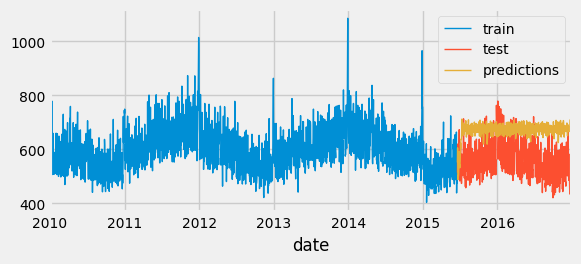

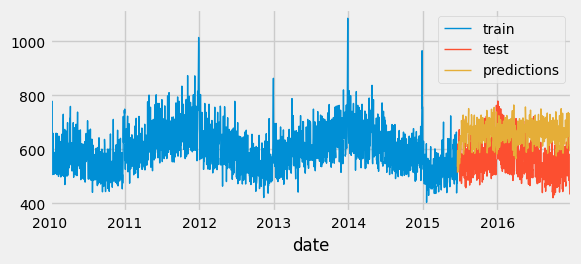

In [45]:
for reg in random_state_regressors:
    # Create and train forecaster
    # ==============================================================================
    forecaster = ForecasterRecursive(
                    regressor = reg(random_state=123),
                    lags      = 6
                )
    forecaster.fit(y=data_train['num_sold'])
    forecaster

    steps = 562
    predictions = forecaster.predict(steps=steps)

    # Plot predictions versus test data
    # ==============================================================================
    fig, ax = plt.subplots(figsize=(6, 2.5))
    data_train['num_sold'].plot(ax=ax, label='train')
    data_test['num_sold'].plot(ax=ax, label='test')
    predictions.plot(ax=ax, label='predictions')
    ax.legend()

    # Test error
    # ==============================================================================
    error_rmse = root_mean_squared_error(
                    y_true = data_test['num_sold'],
                    y_pred = predictions
                )
    error_mape = mean_absolute_percentage_error(
                    y_true = data_test['num_sold'],
                    y_pred = predictions
                )
    print(reg)
    print(f"Test error (RMSE): {round(error_rmse, 2)}")
    print(f"Test error (MAPE): {round(error_mape*100, 2)}%")

In [46]:
estimator_regressors = [SVR]

Test error (RMSE): 66.24
Test error (MAPE): 8.6%


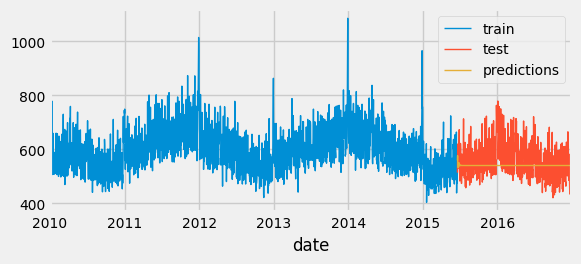

In [47]:
for reg in estimator_regressors:
    # Create and train forecaster
    # ==============================================================================
    forecaster = ForecasterRecursive(
                    regressor = reg(kernel='rbf', C=0.5, epsilon=0.1),
                    lags      = 6
                )
    forecaster.fit(y=data_train['num_sold'])
    forecaster

    steps = 562
    predictions = forecaster.predict(steps=steps)

    # Plot predictions versus test data
    # ==============================================================================
    fig, ax = plt.subplots(figsize=(6, 2.5))
    data_train['num_sold'].plot(ax=ax, label='train')
    data_test['num_sold'].plot(ax=ax, label='test')
    predictions.plot(ax=ax, label='predictions')
    ax.legend()

    # Test error
    # ==============================================================================
    error_rmse = root_mean_squared_error(
                    y_true = data_test['num_sold'],
                    y_pred = predictions
                )
    error_mape = mean_absolute_percentage_error(
                    y_true = data_test['num_sold'],
                    y_pred = predictions
                )
    print(f"Test error (RMSE): {round(error_rmse, 2)}")
    print(f"Test error (MAPE): {round(error_mape*100, 2)}%")


In [48]:
sarimax = [ForecasterSarimax]

Test error (RMSE): 66.24
Test error (MAPE): 8.6%


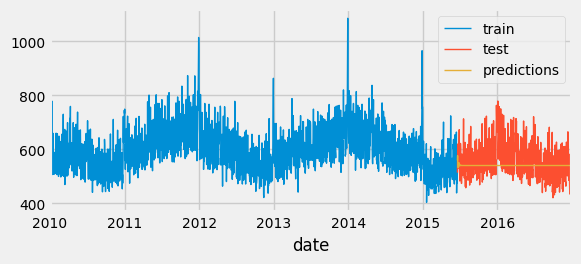

In [49]:
for reg in estimator_regressors:
    # Create and train forecaster
    # ==============================================================================
    forecaster = ForecasterRecursive(
                    regressor = reg(kernel='rbf', C=0.5, epsilon=0.1),
                    lags      = 6
                )
    forecaster.fit(y=data_train['num_sold'])
    forecaster

    steps = 562
    predictions = forecaster.predict(steps=steps)

    # Plot predictions versus test data
    # ==============================================================================
    fig, ax = plt.subplots(figsize=(6, 2.5))
    data_train['num_sold'].plot(ax=ax, label='train')
    data_test['num_sold'].plot(ax=ax, label='test')
    predictions.plot(ax=ax, label='predictions')
    ax.legend()

    # Test error
    # ==============================================================================
    error_rmse = root_mean_squared_error(
                    y_true = data_test['num_sold'],
                    y_pred = predictions
                )
    error_mape = mean_absolute_percentage_error(
                    y_true = data_test['num_sold'],
                    y_pred = predictions
                )
    print(f"Test error (RMSE): {round(error_rmse, 2)}")
    print(f"Test error (MAPE): {round(error_mape*100, 2)}%")

In [50]:
# Libraries
# ======================================================================================
import numpy as np
import pandas as pd
from io import StringIO
import contextlib
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

# pmdarima
import pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
import skforecast
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from skforecast.sarimax import Sarimax
from skforecast.recursive import ForecasterSarimax
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_sarimax
from skforecast.model_selection import grid_search_sarimax

import warnings

In [51]:
example_series = example_df['num_sold']

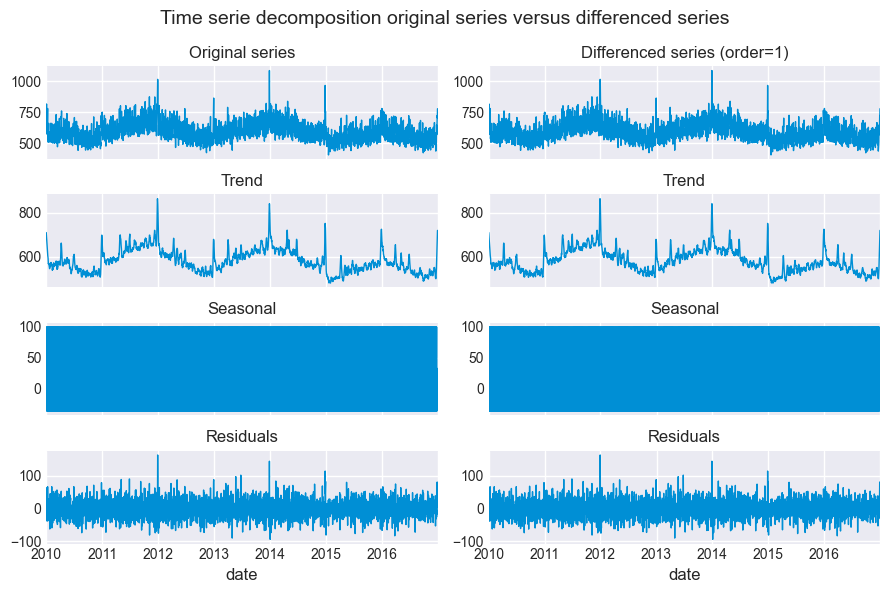

In [52]:
# Time series descoposition of original versus differenced series
# ==============================================================================
res_decompose = seasonal_decompose(example_series, model='additive', extrapolate_trend='freq')
res_descompose_diff_2 = seasonal_decompose(example_series, model='additive', extrapolate_trend='freq')

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)

res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Original series', fontsize=12)
res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Trend', fontsize=12)
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Seasonal', fontsize=12)
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuals', fontsize=12)
res_descompose_diff_2.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Differenced series (order=1)', fontsize=12)
res_descompose_diff_2.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Trend', fontsize=12)
res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Seasonal', fontsize=12)
res_descompose_diff_2.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuals', fontsize=12)
fig.suptitle('Time serie decomposition original series versus differenced series', fontsize=14)
fig.tight_layout()

In [53]:
# ARIMA model with ForecasterSarimax and skforecast Sarimax
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
             )
forecaster.fit(y=data_train['num_sold'], suppress_warnings=True)

# Prediction
predictions = forecaster.predict(steps=len(data_test))

In [54]:
sarimax

[skforecast.recursive._forecaster_sarimax.ForecasterSarimax]

Test error (RMSE): 72.88
Test error (MAPE): 8.65%


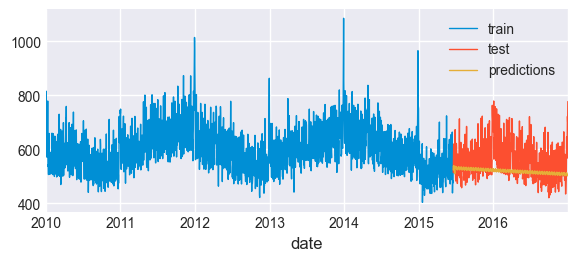

In [55]:
for reg in sarimax:
    # Create and train forecaster
    # ==============================================================================
    forecaster = ForecasterSarimax(
                    regressor = Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)),
                )
    forecaster.fit(y=data_train['num_sold'])
    forecaster

    steps = 562
    predictions = forecaster.predict(steps=steps)

    # Plot predictions versus test data
    # ==============================================================================
    fig, ax = plt.subplots(figsize=(6, 2.5))
    data_train['num_sold'].plot(ax=ax, label='train')
    data_test['num_sold'].plot(ax=ax, label='test')
    predictions.plot(ax=ax, label='predictions')
    ax.legend()

    # Test error
    # ==============================================================================
    error_rmse = root_mean_squared_error(
                    y_true = data_test['num_sold'],
                    y_pred = predictions
                )
    error_mape = mean_absolute_percentage_error(
                    y_true = data_test['num_sold'],
                    y_pred = predictions
                )
    print(f"Test error (RMSE): {round(error_rmse, 2)}")
    print(f"Test error (MAPE): {round(error_mape*100, 2)}%")